# Прототип модели машинного обучения для компании "Цифра"

Цель проекта - подготовка прототипа модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

В ходе проекта выполним следующее:
1. Подготовим данные;
2. Проведем исследовательский анализ данных;
3. Построим и обучим модель, нужно спрогнозировать сразу две величины:
   - эффективность обогащения чернового концентрата rougher.output.recovery;
   - эффективность обогащения финального концентрата final.output.recovery.

### Описание данных:

**Технологический процесс**
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate **— ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

**Параметры этапов**
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

### Наименование признаков

Наименование признаков выглядит следующим образом:
`этап.тип_параметра.название_параметра`

Пример: `rougher.input.feed_ag`

**Возможные значения для блока `этап`:**
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

**Возможные значения для блока `тип_параметра`:**
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

# 1. Подготовка данных

In [1]:
#импортируем необходимые библиотеки и инструменты
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

Необходимые данные находятся в трёх файлах - это исходные данные, обучающая и тестовая выборки. Загрузим их.

In [2]:
train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
full_data = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
#ознакомимся с данными
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

В рамках подготовки данных нам необходимо проверить формулу вычисления эффективности обогащения.
Формула выглядит так:

`recovery = ((C * (F - T)) / (F * (C - T))) * 100%`

где:

- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

Основываясь на полученных от компании данных, необходимые нам признаки для проверки формулы это:
- rougher.output.concentrate_au (С)
- rougher.input.feed_au (F)
- rougher.output.tail_au (T)

А сам результат работы формулы находится здесь:
- rougher.output.recovery 

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака `rougher.output.recovery`. Найдем MAE между нашими расчётами и значением признака.

Создадим новый столбец с результатом вычисления эффективности обогащения по формуле.

In [4]:
#избавимся от пропусков в столбце rougher.output.recovery
train.dropna(subset = ['rougher.output.recovery'], inplace = True)

In [5]:
C = train['rougher.output.concentrate_au']
F = train['rougher.input.feed_au']
T = train['rougher.output.tail_au']

In [6]:
calculation = ((C * (F - T)) / (F * (C - T))) * 100

Построим гистограммы для двух наборов значений recovery - старого и нового.

In [7]:
old_recovery = train['rougher.output.recovery']

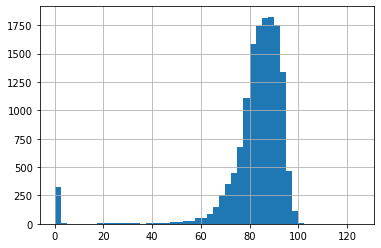

In [8]:
train['rougher.output.recovery'].hist(bins=50, range=(0, 125))

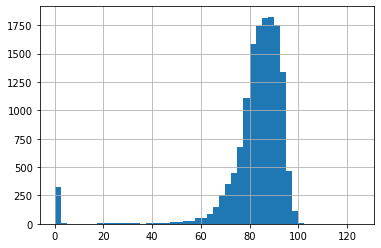

In [9]:
calculation.hist(bins=50, range=(0, 125))

На графиках нет различия в распределении старых и новых данных. Посчитаем MAE и посмотрим на среднее абсолютное отклонение.

In [10]:
print('MAE:', mean_absolute_error(old_recovery, calculation))

MAE: 9.444891926100695e-15


Среднее абсолютное отклонение ничтожно мало. Различий между данными действительно нет, рассчеты верны.

Сравним наполнение обучающей и тестовой выборок.

In [11]:
print(train.shape)
print(test.shape)

(14287, 87)
(5856, 53)


В обущающей выборке признаков гораздо больше. Проанализируем те признаки, которые недоступны в тестовой выборке.

In [12]:
missing_cols = train.columns.drop(test.columns)
train[missing_cols].head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.output.concentrate_ag,...,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,8.547551,...,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,14.500184,4.694824,8.764648,2.606185
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,8.558743,...,20.050975,86.843261,4.955378,0.536689,18.965234,1.184827,14.265474,4.592547,9.001494,2.488248
2,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,8.603505,...,19.737170,86.842308,4.843460,0.546416,18.808533,1.162562,14.115662,4.624775,8.842896,2.458187
3,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,7.221879,...,19.320810,87.226430,4.655288,0.542525,19.330200,1.079755,13.732071,4.482453,9.122857,2.322062
4,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,9.089428,...,19.216101,86.688794,4.552800,0.515438,19.267422,1.012642,14.079996,4.470737,8.871028,2.330448


По сути, все эти столбцы - целевые признаки (в зависимости от того, что именно мы предсказываем). Это концентрация различных веществ на выходе после отчистки, а также доля веществ в отвальных хвостах.

Выходит, у нас есть 53 признака (те, что в тестовой выборке) и 2 целевых признака, как по условию - `rougher.output.recovery` и `final.output.recovery`. Осталось убрать из обучающей выборки ненужные признаки и добавить целевые признаки в тестовую выборку.

In [13]:
cols_to_drop = missing_cols.drop(['final.output.recovery', 'rougher.output.recovery'])
right_cols = train.columns.drop(cols_to_drop)
train = train[right_cols]

Обучающая выборка готова, теперь займемся тестовой. Столбец `date` в исходных данных содержит уникальные значения. Будем использовать эти значения как индексы, чтобы объединить датасеты и добавить в тестовую выборку недостающую информацию.

In [14]:
target_features_to_join = full_data[['date', 'final.output.recovery', 'rougher.output.recovery']].copy()

In [15]:
test = test.join(target_features_to_join.set_index('date'), on='date')

In [16]:
train['final.output.recovery'].isnull().value_counts()

False    14149
True       138
Name: final.output.recovery, dtype: int64

In [17]:
test['final.output.recovery'].isnull().value_counts()

False    5414
True      442
Name: final.output.recovery, dtype: int64

На примере столбца `final.output.recovery` видим, что в обеих выборках есть отсутствующие данные. Избавимся от значений NaN в целевых признаках обеих выборок - такие данные не несут пользы.

In [18]:
train.dropna(subset = ['final.output.recovery', 'rougher.output.recovery'], inplace = True)
test.dropna(subset = ['final.output.recovery', 'rougher.output.recovery'], inplace = True)

In [19]:
test.reset_index(drop=True, inplace=True)
train.reset_index(drop=True, inplace=True)

In [20]:
print(train.shape)
print(test.shape)

(14149, 55)
(5290, 55)


Теперь у нас есть готовые обучающая и тестовая выборки, состоящие из необходимых столбцов и очищенные от наблюдений с пропусками в целевых признаках.

# 2. Анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

In [21]:
#подготовим датасет с необходимыми данными для золота
au_data = (full_data[[
    'rougher.input.feed_au', 
    'rougher.output.concentrate_au', 
    'primary_cleaner.output.concentrate_au', 
    'final.output.concentrate_au']].copy())

In [22]:
#серебра
ag_data = (full_data[[
    'rougher.input.feed_ag', 
    'rougher.output.concentrate_ag', 
    'primary_cleaner.output.concentrate_ag', 
    'final.output.concentrate_ag']].copy())

In [23]:
#свинца
pb_data = (full_data[[
    'rougher.input.feed_pb', 
    'rougher.output.concentrate_pb', 
    'primary_cleaner.output.concentrate_pb', 
    'final.output.concentrate_pb']].copy())

In [24]:
#напишем функцию, которая будет рисовать данные всех четырех столбцов на одном графике
def draw_hist (data, title):
    fig, ax = plt.subplots()
    ax.set_ylabel('Кол-во наблюдений')
    ax.set_xlabel('Концентрация металла')
    ax.set_title(title)
    for col in data:
        data[col].hist(alpha=.3) 
        ax.legend(['Исходное сырье','Флотация','Первичная очистка', 'Вторичная очистка'])

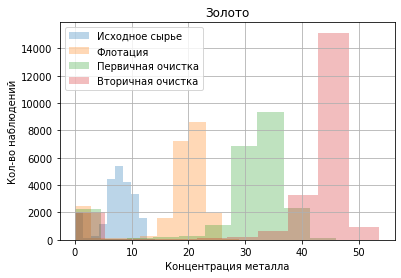

In [25]:
draw_hist(au_data, 'Золото')

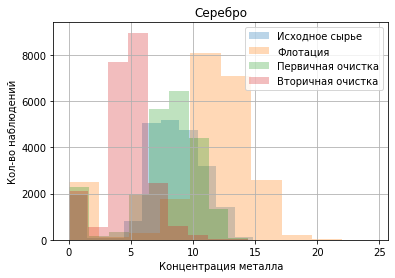

In [26]:
draw_hist(ag_data, 'Серебро')

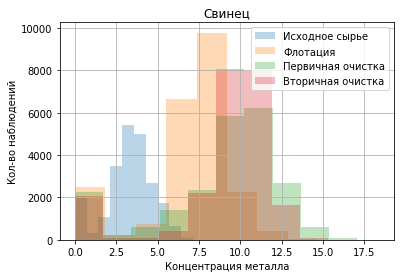

In [27]:
draw_hist(pb_data, 'Свинец')

По графикам можем определить следующее:
1. для разных металлов концентрация на различных этапах очистки отличается. Например, концентрация золота увеличивается с каждым этапом. Концентрация серебра после вторичной очистки меньше, чем в исходном сырье. А у свинца результаты первичной и вторичной очистки почти идентичны.

2. в данных много нулевых значений. Скорее всего, для таких наблюдений не были сделаны замеры по какой-то причине, либо эти данные утрачены. Впоследствии нужно будет избавиться от таких данных, они могут повлиять на качество модели.

У нас есть два признака с параметром `feed_size` в обучающей и тестовой выборках -  `rougher.input.feed_size` и `primary_cleaner.input.feed_size`. Сравним их распределения. Если они сильно отличаются друг от друга, оценка модели будет неправильной.

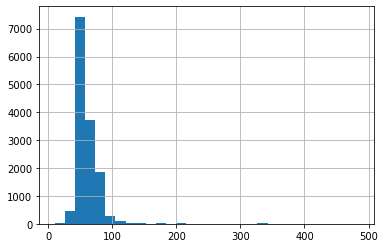

In [28]:
train['rougher.input.feed_size'].hist(bins=30)

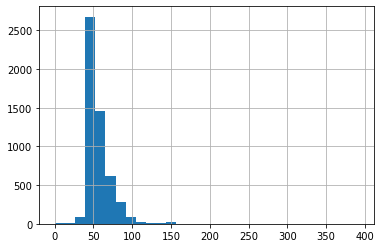

In [29]:
test['rougher.input.feed_size'].hist(bins=30)

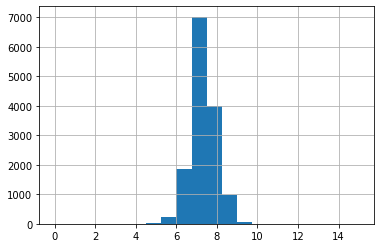

In [30]:
train['primary_cleaner.input.feed_size'].hist(bins=20, range=(0, 15))

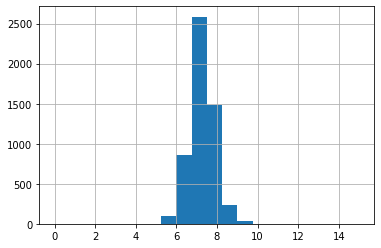

In [31]:
test['primary_cleaner.input.feed_size'].hist(bins=20, range=(0, 15))

Для обоих параметров распределения не сильно отличаются друг от друга, такие неточности не должны критично повлиять на работу модели.

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

In [32]:
#создадим новый датасет с данныим о концентрации веществ и просуммируем их концентрацию на разных стадиях
concentrate_data = full_data[['date','rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au']].copy()
concentrate_data['conc_sum_rougher'] = concentrate_data['rougher.input.feed_ag'] + concentrate_data['rougher.input.feed_pb'] + concentrate_data['rougher.input.feed_sol'] + concentrate_data['rougher.input.feed_au']
concentrate_data['conc_sum_primary'] = concentrate_data['primary_cleaner.output.concentrate_ag'] + concentrate_data['primary_cleaner.output.concentrate_pb'] + concentrate_data['primary_cleaner.output.concentrate_sol'] + concentrate_data['primary_cleaner.output.concentrate_au']
concentrate_data['conc_sum_final'] = concentrate_data['final.output.concentrate_ag'] + concentrate_data['final.output.concentrate_pb'] + concentrate_data['final.output.concentrate_sol'] + concentrate_data['final.output.concentrate_au']


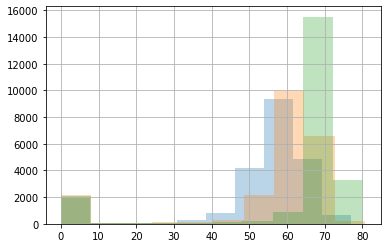

In [33]:
#построим гистограммы для суммарных концентраций веществ
concentrate_data['conc_sum_rougher'].hist(alpha=.3)
concentrate_data['conc_sum_primary'].hist(alpha=.3)
concentrate_data['conc_sum_final'].hist(alpha=.3)

По графикам видим, что в суммарных данных много нулевых или близких к нулю значений. Нужно избавиться от наблюдений с такими аномалиями, чтобы они не повлияли на качество модели.

In [34]:
#создадим датасет с аномальными наблюдениями
anomaly = (concentrate_data[['date', 'conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']]
           .copy()
           .query('conc_sum_rougher == 0 or conc_sum_primary == 0 or conc_sum_final == 0')
           .fillna(0))

In [35]:
anomaly.head()

,date,conc_sum_rougher,conc_sum_primary,conc_sum_final
19,2016-01-15 19:00:00,56.005644,0.0,64.546766
22,2016-01-15 22:00:00,56.038252,0.0,64.554911
30,2016-01-16 06:00:00,57.764677,0.0,63.765751
73,2016-01-18 01:00:00,56.626743,0.0,65.773298
76,2016-01-18 04:00:00,56.369424,0.0,59.902215


Избавимся от аномальных значений в тестовой выборке.

In [36]:
test = test.join(anomaly.set_index('date'), on='date')

In [37]:
test[['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']] = (test[['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']]
                                                                    .fillna(-1))

In [38]:
test = test.query('conc_sum_rougher == -1 and conc_sum_primary == -1 and conc_sum_final == -1')

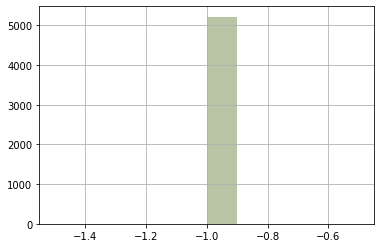

In [39]:
#проверим, что все выполнилось правильно - значением всех признаков должно быть -1
test['conc_sum_rougher'].hist(alpha=.2)
test['conc_sum_primary'].hist(alpha=.2)
test['conc_sum_final'].hist(alpha=.2)

In [40]:
#избавимся от ненужных столбцов
test.drop(['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final'], axis='columns', inplace=True)

Теперь удалим аномальные значения из обучающей выборки.

In [41]:
train = train.join(anomaly.set_index('date'), on='date')
train[['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']] = (train[['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']]
                                                                    .fillna(-1))
train = train.query('conc_sum_rougher == -1 and conc_sum_primary == -1 and conc_sum_final == -1')
train.drop(['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final'], axis='columns', inplace=True)

In [42]:
#удалим из выборок оставшиеся NaN-значения
test.dropna(inplace=True)
train.dropna(inplace=True)

In [43]:
print(train.shape)
print(test.shape)

(12593, 55)
(5169, 55)


Выборки готовы, можно строить модель.

# 3. Модель

Напишем функцию для рассчета метрики качества модели - sMAPE (Symmetric Mean Absolute Percentage Error).

In [44]:
def smape (target, predictions):
    return 100/len(target) * np.sum(2 * np.abs(predictions - target) / (np.abs(target) + np.abs(predictions)))

А также функцию для рассчета итогового sMAPE.

In [45]:
def final_smape (rougher, final):
    return 0.25 * rougher + 0.75 * final

Подготовим features и target для обучающей выборки.

In [46]:
target_rougher = train['rougher.output.recovery']
target_final = train['final.output.recovery']

features_train = train.drop(['date', 'final.output.recovery', 'rougher.output.recovery'], axis='columns')

Масштабируем признаки.

In [47]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)

Проверим несколько моделей методом кросс-валидации и выберем лучший результат.

In [48]:
model_dtr = DecisionTreeRegressor(random_state=666)
cross_val_score(model_dtr, features_train, target_rougher, cv=3).mean()

-2.7175562145623378

In [49]:
model_lr = LinearRegression()
cross_val_score(model_lr, features_train, target_rougher, cv=3).mean()

-0.3487050264428391

In [50]:
model_cb = CatBoostRegressor(iterations=2, learning_rate=1, depth=3)
cross_val_score(model_cb, features_train, target_rougher, cv=3).mean()

0:	learn: 11.1329495	total: 49.9ms	remaining: 49.9ms
1:	learn: 10.4442662	total: 52.5ms	remaining: 0us
0:	learn: 10.1677055	total: 2.75ms	remaining: 2.75ms
1:	learn: 9.3199235	total: 5.52ms	remaining: 0us
0:	learn: 10.4215079	total: 3.02ms	remaining: 3.02ms
1:	learn: 10.2394145	total: 5.51ms	remaining: 0us


-0.28220678979887664

In [51]:
model_rf = RandomForestRegressor(random_state=666, n_estimators=10)
cross_val_score(model_rf, features_train, target_rougher, cv=3).mean()

-0.5657745642583006

Лучший результат показывает модель CatBoost. Обучим её. 

Подготовим features и target для тестовой выборки и масштабируем признаки.

In [52]:
target_rougher_test = test['rougher.output.recovery']
target_final_test = test['final.output.recovery']

features_test = test.drop(['date', 'final.output.recovery', 'rougher.output.recovery'], axis='columns')

In [53]:
scaler = StandardScaler()
scaler.fit(features_test)
features_test = scaler.transform(features_test)

Обучим модель и получим предсказания.

In [54]:
model_cb = CatBoostRegressor(iterations=2, learning_rate=1, depth=3)
model_cb_1 = CatBoostRegressor(iterations=2, learning_rate=1, depth=3)

cb_rougher = model_cb.fit(features_train, target_rougher)
cb_final = model_cb_1.fit(features_train, target_final)

cb_predictions_rougher = cb_rougher.predict(features_test)
cb_predictions_final = cb_final.predict(features_test)

0:	learn: 11.2530953	total: 3.48ms	remaining: 3.48ms
1:	learn: 10.6255644	total: 6.55ms	remaining: 0us
0:	learn: 7.4506003	total: 3.36ms	remaining: 3.36ms
1:	learn: 7.1999674	total: 6.47ms	remaining: 0us


Посчитаем sMAPE для обоих признаков и итоговый.

In [55]:
smape_rougher = smape(target_rougher_test, cb_predictions_rougher)

In [56]:
smape_final = smape(target_final_test, cb_predictions_final)

In [57]:
final_smape(smape_rougher, smape_final)

8.513991726278483

Проверим качество модели, сравнив с константной. Для этого будем использовать модель DummyRegressor.

In [58]:
dummy = DummyRegressor(strategy = 'mean')
dummy_1 = DummyRegressor(strategy = 'mean')

dummy_rougher = dummy.fit(features_train, target_rougher)
dummy_predictions_rougher = dummy_rougher.predict(features_test)

dummy_final = dummy_1.fit(features_train, target_final)
dummy_predictions_final = dummy_final.predict(features_test)

In [59]:
smape_rougher_dummy = smape(target_rougher_test, dummy_predictions_rougher)

In [60]:
smape_final_dummy = smape(target_final_test, dummy_predictions_final)

In [61]:
final_smape(smape_rougher_dummy, smape_final_dummy)

8.873662390741785

Обученная модель предсказывает результат точнее константной. Это говорит о том, что построенная модель адекватна.

**Вывод:**
1. Написали функции для рассчета sMAPE и итогового sMAPE.
2. Проверили несколько формул кросс-валидацией.
3. Проверили работу модели на тестовой выборке с помощью метрики качества sMAPE и сравнения с константной моделью.
4. Подготовили прототип модели машинного обучения для «Цифры»